In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('E:/2024/July2024/Fault_Classification/Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


E:/2024/July2024/Fault_Classification/Dataset\CWRU_48k_load_1_CNN_data.npz
E:/2024/July2024/Fault_Classification/Dataset\feature_time_48k_2048_load_1.csv
E:/2024/July2024/Fault_Classification/Dataset\raw\B007_1_123.mat
E:/2024/July2024/Fault_Classification/Dataset\raw\B014_1_190.mat
E:/2024/July2024/Fault_Classification/Dataset\raw\B021_1_227.mat
E:/2024/July2024/Fault_Classification/Dataset\raw\IR007_1_110.mat
E:/2024/July2024/Fault_Classification/Dataset\raw\IR014_1_175.mat
E:/2024/July2024/Fault_Classification/Dataset\raw\IR021_1_214.mat
E:/2024/July2024/Fault_Classification/Dataset\raw\OR007_6_1_136.mat
E:/2024/July2024/Fault_Classification/Dataset\raw\OR014_6_1_202.mat
E:/2024/July2024/Fault_Classification/Dataset\raw\OR021_6_1_239.mat
E:/2024/July2024/Fault_Classification/Dataset\raw\Time_Normal_1_098.mat


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('E:/2024/July2024/Fault_Classification/Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

E:/2024/July2024/Fault_Classification/Dataset\CWRU_48k_load_1_CNN_data.npz
E:/2024/July2024/Fault_Classification/Dataset\feature_time_48k_2048_load_1.csv
E:/2024/July2024/Fault_Classification/Dataset\raw\B007_1_123.mat
E:/2024/July2024/Fault_Classification/Dataset\raw\B014_1_190.mat
E:/2024/July2024/Fault_Classification/Dataset\raw\B021_1_227.mat
E:/2024/July2024/Fault_Classification/Dataset\raw\IR007_1_110.mat
E:/2024/July2024/Fault_Classification/Dataset\raw\IR014_1_175.mat
E:/2024/July2024/Fault_Classification/Dataset\raw\IR021_1_214.mat
E:/2024/July2024/Fault_Classification/Dataset\raw\OR007_6_1_136.mat
E:/2024/July2024/Fault_Classification/Dataset\raw\OR014_6_1_202.mat
E:/2024/July2024/Fault_Classification/Dataset\raw\OR021_6_1_239.mat
E:/2024/July2024/Fault_Classification/Dataset\raw\Time_Normal_1_098.mat


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Load the dataset
data_time = pd.read_csv("E:/2024/July2024/Fault_Classification/Dataset/feature_time_48k_2048_load_1.csv")

# Scale each column to have zero mean and standard deviation equal to 1
scaler = StandardScaler()
train_data, test_data = train_test_split(data_time, test_size=750, stratify=data_time['fault'], random_state=1234)

# Scale the training data
train_data_scaled = scaler.fit_transform(train_data.iloc[:, :-1])
train_data_scaled = torch.tensor(train_data_scaled, dtype=torch.float32)
#train_labels = torch.tensor(train_data['fault'].values)

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_data['fault'])
train_labels = torch.tensor(train_labels_encoded, dtype=torch.int64)  # Use dtype=torch.int64 for labels

# Scale the testing data
test_data_scaled = (test_data.iloc[:, :-1].values - scaler.mean_) / np.sqrt(scaler.var_)
test_data_scaled = torch.tensor(test_data_scaled, dtype=torch.float32)
#test_labels = torch.tensor(test_data['fault'].values)

test_labels_encoded = label_encoder.transform(test_data['fault'])
test_labels = torch.tensor(test_labels_encoded, dtype=torch.int64)  # Use dtype=torch.int64 for labels

# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx].unsqueeze(0), 'label': self.labels[idx]}
        return sample

# Create data loaders
batch_size = 32

train_dataset = CustomDataset(train_data_scaled, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(test_data_scaled, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define simple 1DCNN model
class Simple1DCNN(nn.Module):

    def __init__(self, input_channels, output_size):

        super(Simple1DCNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)

        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3)

        self.fc1 = nn.Linear(64, 64)

        self.fc2 = nn.Linear(64, output_size)

        self.relu = nn.ReLU()

        self.maxpool = nn.MaxPool1d(kernel_size=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)

        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        if x.size(2) > 1:
            x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        if x.size(2) > 1:
            x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = Simple1DCNN(input_channels=train_data_scaled.shape[1], output_size=len(data_time['fault'].unique()))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch['data'], batch['label']

        optimizer.zero_grad()

        outputs = model(inputs)  # Directly pass inputs to the model
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# Evaluate the model on test data
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch['data'], batch['label']
        outputs = model(inputs)  # Directly pass inputs to the model
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on test set: {accuracy}")

Epoch 1/50, Loss: 1.7998781982733278
Epoch 2/50, Loss: 0.7932174449064293
Epoch 3/50, Loss: 0.4479760998974041
Epoch 4/50, Loss: 0.3423018832595981
Epoch 5/50, Loss: 0.29096148421569745
Epoch 6/50, Loss: 0.2518834575858651
Epoch 7/50, Loss: 0.21906124047782957
Epoch 8/50, Loss: 0.21456652362735903
Epoch 9/50, Loss: 0.19962114042469434
Epoch 10/50, Loss: 0.17948924704473845
Epoch 11/50, Loss: 0.17221002417559528
Epoch 12/50, Loss: 0.16642677400033085
Epoch 13/50, Loss: 0.16249842413378005
Epoch 14/50, Loss: 0.1579491511291387
Epoch 15/50, Loss: 0.15798210747996155
Epoch 16/50, Loss: 0.14940953818244898
Epoch 17/50, Loss: 0.14376645546634587
Epoch 18/50, Loss: 0.15174377664011351
Epoch 19/50, Loss: 0.14032090135983058
Epoch 20/50, Loss: 0.14571226359706144
Epoch 21/50, Loss: 0.14571177894819756
Epoch 22/50, Loss: 0.13126391639971002
Epoch 23/50, Loss: 0.14797598864807157
Epoch 24/50, Loss: 0.14874223874387693
Epoch 25/50, Loss: 0.1388743736458068
Epoch 26/50, Loss: 0.11974714776234967
Ep

Epoch 1/50, Loss: 1.7900366491200972
Epoch 2/50, Loss: 0.7708828510070334
Epoch 3/50, Loss: 0.4432401565872893
Epoch 4/50, Loss: 0.37561218562174814
Epoch 5/50, Loss: 0.3304182643793067
Epoch 6/50, Loss: 0.2942331229545632
Epoch 7/50, Loss: 0.267749661997873
Epoch 8/50, Loss: 0.24247449089069756
Epoch 9/50, Loss: 0.2241469674876758
Epoch 10/50, Loss: 0.21737970198903764
Epoch 11/50, Loss: 0.20068670094621424
Epoch 12/50, Loss: 0.1970485093794307
Epoch 13/50, Loss: 0.17336606249517325
Epoch 14/50, Loss: 0.16909804864197361
Epoch 15/50, Loss: 0.16254244919638244
Epoch 16/50, Loss: 0.15859881872121168
Epoch 17/50, Loss: 0.1569595019504124
Epoch 18/50, Loss: 0.1521912625211538
Epoch 19/50, Loss: 0.15497143030622784
Epoch 20/50, Loss: 0.1470730158747459
Epoch 21/50, Loss: 0.143495058716864
Epoch 22/50, Loss: 0.1469070841083113
Epoch 23/50, Loss: 0.14124490898482653
Epoch 24/50, Loss: 0.13185214087823216
Epoch 25/50, Loss: 0.13217600967202867
Epoch 26/50, Loss: 0.1321937425860337
Epoch 27/50

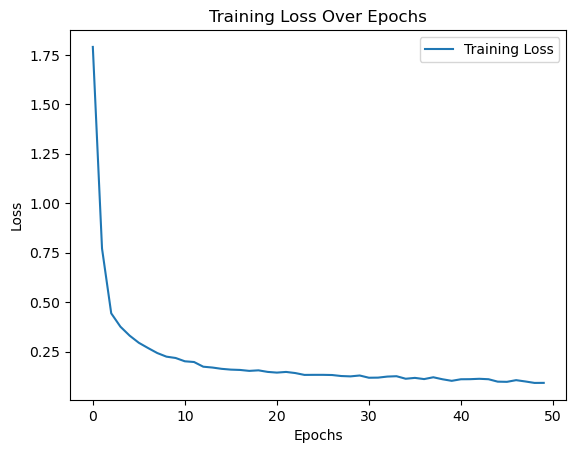

Accuracy on test set: 0.9653333333333334

Classification Report:
              precision    recall  f1-score   support

  Ball_007_1       0.97      0.99      0.98        75
  Ball_014_1       0.87      0.89      0.88        75
  Ball_021_1       1.00      0.88      0.94        75
    IR_007_1       1.00      1.00      1.00        75
    IR_014_1       1.00      1.00      1.00        75
    IR_021_1       1.00      1.00      1.00        75
    Normal_1       0.97      0.97      0.97        75
  OR_007_6_1       1.00      1.00      1.00        75
  OR_014_6_1       0.86      0.92      0.89        75
  OR_021_6_1       0.99      1.00      0.99        75

    accuracy                           0.97       750
   macro avg       0.97      0.97      0.97       750
weighted avg       0.97      0.97      0.97       750



In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load the dataset
data_time = pd.read_csv("C:/Users/OKOK PRO/Downloads/CODE_Fault_Classification/Dataset/feature_time_48k_2048_load_1.csv")

# Scale each column to have zero mean and standard deviation equal to 1
scaler = StandardScaler()
train_data, test_data = train_test_split(data_time, test_size=750, stratify=data_time['fault'], random_state=1234)

# Scale the training data
train_data_scaled = scaler.fit_transform(train_data.iloc[:, :-1])
train_data_scaled = torch.tensor(train_data_scaled, dtype=torch.float32)

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_data['fault'])
train_labels = torch.tensor(train_labels_encoded, dtype=torch.int64)  # Use dtype=torch.int64 for labels

# Scale the testing data
test_data_scaled = (test_data.iloc[:, :-1].values - scaler.mean_) / np.sqrt(scaler.var_)
test_data_scaled = torch.tensor(test_data_scaled, dtype=torch.float32)

test_labels_encoded = label_encoder.transform(test_data['fault'])
test_labels = torch.tensor(test_labels_encoded, dtype=torch.int64)  # Use dtype=torch.int64 for labels

# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx].unsqueeze(0), 'label': self.labels[idx]}
        return sample

# Create data loaders
batch_size = 32

train_dataset = CustomDataset(train_data_scaled, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(test_data_scaled, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define simple 1DCNN model
class Simple1DCNN(nn.Module):

    def __init__(self, input_channels, output_size):
        super(Simple1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        if x.size(2) > 1:
            x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        if x.size(2) > 1:
            x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = Simple1DCNN(input_channels=train_data_scaled.shape[1], output_size=len(data_time['fault'].unique()))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch['data'], batch['label']
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

# Plot the loss over epochs
plt.plot(range(num_epochs), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Evaluate the model on test data
model.eval()
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch['data'], batch['label']
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = correct / total
print(f"Accuracy on test set: {accuracy}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
